# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# load dependencies
import pickle
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import scipy.misc
import pandas
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from sklearn.utils import shuffle

from tensorflow.contrib.layers import flatten
import tensorflow as tf
import math
import time

%matplotlib inline

In [3]:
# load training and test data
training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.bincount(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image data type is", type(X_train[0]))
print("Labels data is 1-D array of type uint8", y_train.shape)
print("Number of classes =", n_classes)
print(X_train.dtype, X_test.dtype)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Image data type is <class 'numpy.ndarray'>
Labels data is 1-D array of type uint8 (39209,)
Number of classes = 43
uint8 uint8


### Visualize the data

Index(['ClassId', 'SignName'], dtype='object')


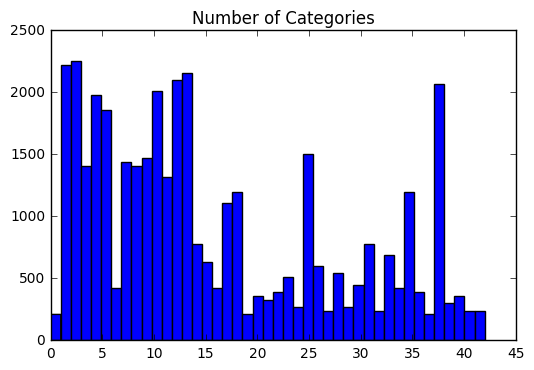

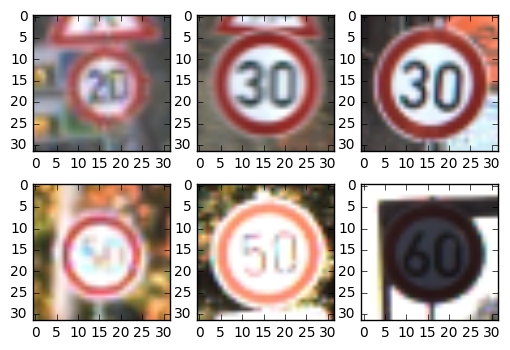

In [6]:
df = pandas.read_csv('data/signnames.csv')
print(df.keys())
plt.hist(y_train, bins=n_classes)
plt.title('Number of Categories')
plt.plot()
plt.show()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i*1000+1])

In [7]:
# we will use YUV since the paper referenced in the lectures had most
# success with that color space
def change_color_space(img, cspace="RGB"):
    # convert image to new color space (if specified)
    # image must be in RGB format, not BGR 
    if cspace != 'RGB':
        if cspace == 'HSV':
            image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'BGR':
            image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else: image = np.copy(img)
    return image

# grab the Y channel from a YUV image
def gray(img):
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    return img[:,:,0]

# normalize the images -1.0 to 1.0
def norm(img):
    return img/127.5 - 1.0

# we will apply random brightness changes to help train on different
# brightness conditions (sunny, dary, cloudy, etc)
def change_brightness(img):
    # Convert the image to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Compute random scale factor from .25 to 1.25
    a = 0.25 + np.random.uniform()
    scaled = np.zeros_like(img)
    scaled = cv2.convertScaleAbs(img, scaled, a)
    
    # Convert back to BGR and return
    img = cv2.cvtColor(scaled, cv2.COLOR_HSV2BGR)
    return img

# we will apply random image transformations to help train at different
# viewing angles
# kudos to Vivek for his blog article with this technique
# https://github.com/vxy10/ImageAugmentation
def transform_image(img,ang_range,shear_range,trans_range):
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

# for now, just grayscale the YUV colorspace and normalize from 1.0 to 1.0
def preprocess_image(img):
    img = change_color_space(img, cspace="YUV")
    img = gray(img)
    img = norm(img)
    return img

# preprocess the images 
def preprocess_image_pipeline(imgs):
    images = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
    for i in tqdm(range(imgs.shape[0])):
        images[i] = preprocess_image(imgs[i])
    return images

# generate n_transforms of training data per img
# params: the preprocess images, labels, and desired number of transformations
def augmentation_pipeline(images, labels, n_transforms=2):
    batch_size = images.shape[0]
    images_outputs = []
    labels_outputs = []
    for i in tqdm(range(batch_size)): # number of augmentation steps
        for t in range(n_transforms):
            gen_image = transform_image(images[i], 20, 10, 5)
            #gen_image = np.reshape(gen_image, (32, 32, 1))   
            images_outputs.append(gen_image)
            labels_outputs.append(labels[i])
    
    return np.array(images_outputs), np.array(labels_outputs)

In [8]:
X_proc = preprocess_image_pipeline(X_train)
X_proc_test = preprocess_image_pipeline(X_test)

100%|██████████| 12630/12630 [00:00<00:00, 36840.73it/s]


In [9]:
print(X_train.dtype, X_test.dtype)
print(X_proc.dtype, X_proc_test.dtype)

uint8 uint8
float64 float64


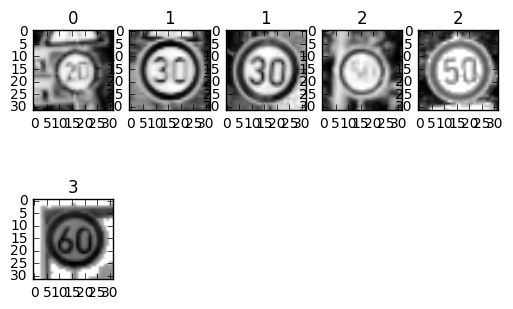

In [10]:
for i in range(6):
    plt.subplot(2,5,i+1)
    plt.imshow(X_proc[i*1000+1], cmap="gray")
    plt.title(y_train[i*1000+1])
gs1 = gridspec.GridSpec(1, 6)
gs1.update(wspace=0.0, hspace=0.8) # set the spacing between axes.
plt.figure()
plt.show()

In [11]:
# split the training data into training and validation data
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_proc,
    y_train,
    test_size = 0.20,
    random_state=23333)

In [12]:
train_features = np.reshape(train_features, (-1,32,32,1))
valid_features = np.reshape(valid_features, (-1,32,32,1))
test_features = np.reshape(X_proc_test, (-1,32,32,1))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### LeNet -5 Archetecure from Udacity Lesson

In [13]:
n_classes = 43
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [14]:
# training features vs validation features
print(train_features.dtype, valid_features.dtype)
# training features vs test features
print(train_features.dtype, test_features.dtype)
# train labels vs validation labels
print(train_labels.dtype, valid_labels.dtype)
# train labels vs test labels
print(train_labels.dtype, y_test.dtype)

# training features vs validation features
print(train_features.shape, valid_features.shape)
# training features vs test features
print(train_features.shape, test_features.shape) 
# train labels vs validation labels
print(train_labels.shape, valid_labels.shape)
# train labels vs test labels
print(train_labels.shape, y_test.shape)

float64 float64
float64 float64
uint8 uint8
uint8 uint8
(31367, 32, 32, 1) (7842, 32, 32, 1)
(31367, 32, 32, 1) (12630, 32, 32, 1)
(31367,) (7842,)
(31367,) (12630,)


In [15]:
x = tf.placeholder("float", (None, 32, 32, 1))
y = tf.placeholder("uint8", (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

### Training Pipeline

In [16]:
lr = 0.001

logits = LeNet(x, keep_prob)
print(logits)
print(one_hot_y)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_operation = optimizer.minimize(loss_operation)

Tensor("add_4:0", shape=(?, 43), dtype=float32)
Tensor("one_hot:0", dtype=float32)


### Model Evaluation Pipeline
* compare a logit prediction to a one-hot-encoded ground truth label
* calc model's overal accuracy by averaging the indivdual prediction accuracies

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))
saver = tf.train.Saver()

def evaluate(X_data, y_data, dropout):
    num_ex = len(y_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_ex, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy/num_ex


### Train the Model

In [18]:
epochs = 40
batch_size = 128
with tf.Session() as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_features)
    
    print("Training....")
    print()
    for i in range(epochs):
        train_features, train_labels = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = train_features[offset:end], train_labels[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
        validation_accuracy = evaluate(valid_features, valid_labels, 1.)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training....

EPOCH 1 ...
Validation Accuracy = 0.768

EPOCH 2 ...
Validation Accuracy = 0.881

EPOCH 3 ...
Validation Accuracy = 0.921

EPOCH 4 ...
Validation Accuracy = 0.934

EPOCH 5 ...
Validation Accuracy = 0.950

EPOCH 6 ...
Validation Accuracy = 0.957

EPOCH 7 ...
Validation Accuracy = 0.965

EPOCH 8 ...
Validation Accuracy = 0.969

EPOCH 9 ...
Validation Accuracy = 0.971

EPOCH 10 ...
Validation Accuracy = 0.974

EPOCH 11 ...
Validation Accuracy = 0.978

EPOCH 12 ...
Validation Accuracy = 0.978

EPOCH 13 ...
Validation Accuracy = 0.979

EPOCH 14 ...
Validation Accuracy = 0.978

EPOCH 15 ...
Validation Accuracy = 0.983

EPOCH 16 ...
Validation Accuracy = 0.982

EPOCH 17 ...
Validation Accuracy = 0.983

EPOCH 18 ...
Validation Accuracy = 0.980

EPOCH 19 ...
Validation Accuracy = 0.982

EPOCH 20 ...
Validation Accuracy = 0.982

EPOCH 21 ...
Validation Accuracy = 0.986

EPOCH 22 ...
Validation Accuracy = 0.979

EPOCH 23 ...
Validation Accuracy = 0.987

EPOCH 24 ...
Validation Accur

### Evaluate the Model

In [19]:
model = './lenet'

In [20]:
with tf.Session() as sess:
    print ('Re-loading saved model' + model)
    saver.restore(sess, model)

    test_accuracy = evaluate(test_features, y_test, 1.0)
    print("Accuracy = {:.1f}% accurancy".format(test_accuracy*100))

Re-loading saved model./lenet
Accuracy = 94.8% accurancy


In [21]:
# training features vs validation features
print(train_features.dtype, valid_features.dtype)
# training features vs test features
print(train_features.dtype, X_proc_test.dtype)
# train labels vs validation labels
print(train_labels.dtype, valid_labels.dtype)
# train labels vs test labels
print(train_labels.dtype, y_test.dtype)

# training features vs validation features
print(train_features.shape, valid_features.shape)
# training features vs test features
print(train_features.shape, X_proc_test.shape) 
# train labels vs validation labels
print(train_labels.shape, valid_labels.shape)
# train labels vs test labels
print(train_labels.shape, y_test.shape)

float64 float64
float64 float64
uint8 uint8
uint8 uint8
(31367, 32, 32, 1) (7842, 32, 32, 1)
(31367, 32, 32, 1) (12630, 32, 32)
(31367,) (7842,)
(31367,) (12630,)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**


I preprocessed the data by changing the color space to YUV. Then I grayscalled the images by taking the Y channel. Finally, I normalized the images from -1.0 to 1.0

These techniques help the training algroithm process data faster and the YUV colorspace has been reported to be the most successful colorspace from the research paper that was referenced in the lesson's learning module.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I used scikit learn train_test_split to split 20% of the training data into validation data. I leave the pickle file called test.p alone to use as the testing data after the model has been trained and validated enough times to give me confidence that I will get good results with the testing data.

I generated additioal data because I want to give the model a greater varity of image conditions (in terms of brightness and perspective) to learn from

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I used the LeNet-5 model that was given in the lecture. I originally started this project before that archetecture and video walkthrough had been given as a starting guide. I had been trying to implement a different, more simple CNN archtechture, but was struck with many errors in implemention. Everything from mismatched shapes, Out of memory, struggles with image proprocessing and augmentation, etc. I left my old answer to this question below for record keeping purposes

First layer is a convolutional layer with filter shape of (5 x 5). The filter shape is an important parameter in convolutional layers because it tells the network how big of a patch to scan the pixels on. In this case, it is 5 x 5 pixels. 

The next layer is a relu activation layer, also know as a rectified linear unit. This layer is placed in between the convolutional layer and the next convolutional layer in order to make the model non-linear.  I also follow the convolutional layers with a maxpooling layer. Maxpooling layer has a kernel size of 2 x 2. This means that the max pooling layer takes a 2px by 2px filter and grabs the maximum value in the filter and drops out the others. This reduces the size of the input and allows the neural network to focus on the most important features.

 Next is another convolutional layer, followed by another relu layer, and a maxpooling layer.

Then I add a regular fully connected layer followed by a rely activation.

Next, I introduce a dropout layer which greatly improved my model’s performance on the test set. This layer was fed with a dropout parameter of 0.5 during training and 1.0 during testing. This tells the network to randomly drop 50% of its activations during training which forces the network to become redundant to itself. By setting dropout to 1.0 during test, we utilize the full power of the network.

After dropout, I finish up with two more fully connected layers with a relu layer in between. The last FC layer is our classification layer. 

In [ ]:

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


I left most knobs unchanged from the Udacity lab. I Used Adam optimizer, batch size of 128, 20 epochs, mean = 0, and standard deviation = 0.1 hyperparameters. Increasing epochs and changing colorspace is all I needed to do to get 98% validation accuraccy and 92.7% test accuracy.

__Update 02-16-17__
I increased epochs by 2x to 40 and test accuracy improved marginally to 94.8 percent. I understand that increased epochs can lead to overtaking/overfitting. But I'm really curious to see the results for myself. As we learned in an early lecture, sometimes the validation accuracy can remain flat for _n_ amount of epochs,  then continue to decrease. 

Validation accuracy barely improved more than 1/10th of a percent over the last 20 epochs, but it also did not decrease. Test accuracy also improved by about 2 percent, which leads me to believe that the model has not overfitted yet.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

I started with the lenet-5 archetecture which is a good CNN archetecture for this problem. CNN's share their parameters across space which means that the network can recognise features regardless of where they are located in the image.

This is perfect for traffic sign classifaction because traffic signs have unique features that the CNN will learn to recognize!

The pooling layers are used to decrease the size of the output convolutional layer which also helps prevent overfitting. Mathematically, the pooling layers using a small filter to scan the convolutional layer for it's largest features and use those as the next inputs for the next layer. In lenet-5, we use pooling layer with filter size of 2 and stride of 2 after both convolutional layers.

I updated my model with dropout after my first submission and noticed good results by adding that layer.

Relu activation layers were used between all layers in order to make the network non-linear.

My main approach to this problem, given the good starting point from the lecture was to keep tabular records of my training iterations along with their respective hyper parameters and preprocessing techniques. You can take a look at the spreadsheet submitted with the assignment for more detail. The biggest benefits came simply by changing the color space of the images and training for more epochs. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [34]:
new_images = []
for i in range(5):
    img = mpimg.imread('test_images/test_image_' + str(i) + '.jpg')
    dst = cv2.resize(img, (32,32), cv2.INTER_AREA)
    print(dst.shape)
    new_images.append(dst)
new_images = np.asarray(new_images)
print(new_images.shape)

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(5, 32, 32, 3)


100%|██████████| 5/5 [00:00<00:00, 4541.26it/s]


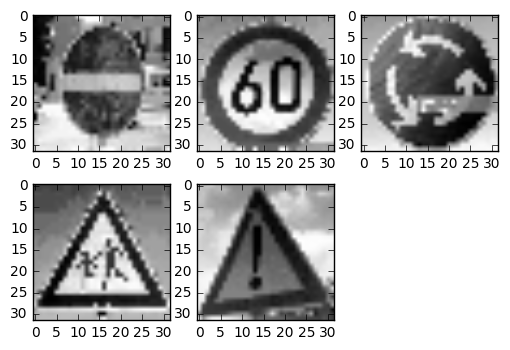

In [35]:
new_images = preprocess_image_pipeline(new_images)

# plot new images
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(new_images[i], cmap="gray")

gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.5, hspace=0.5) # set the spacing between axes.
plt.figure()
plt.show()

ERROR:root:Line magic function `%matplotlibinline` not found.


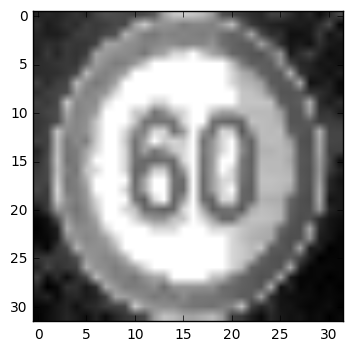

In [36]:
%matplotlibinline
img = mpimg.imread("test_images/60_new.jpg")
img = dst = cv2.resize(img, (32,32), cv2.INTER_AREA)
img = preprocess_image(img)
plt.imshow(img, cmap="gray")

In [37]:
print(len(speed_limit_60))

1410


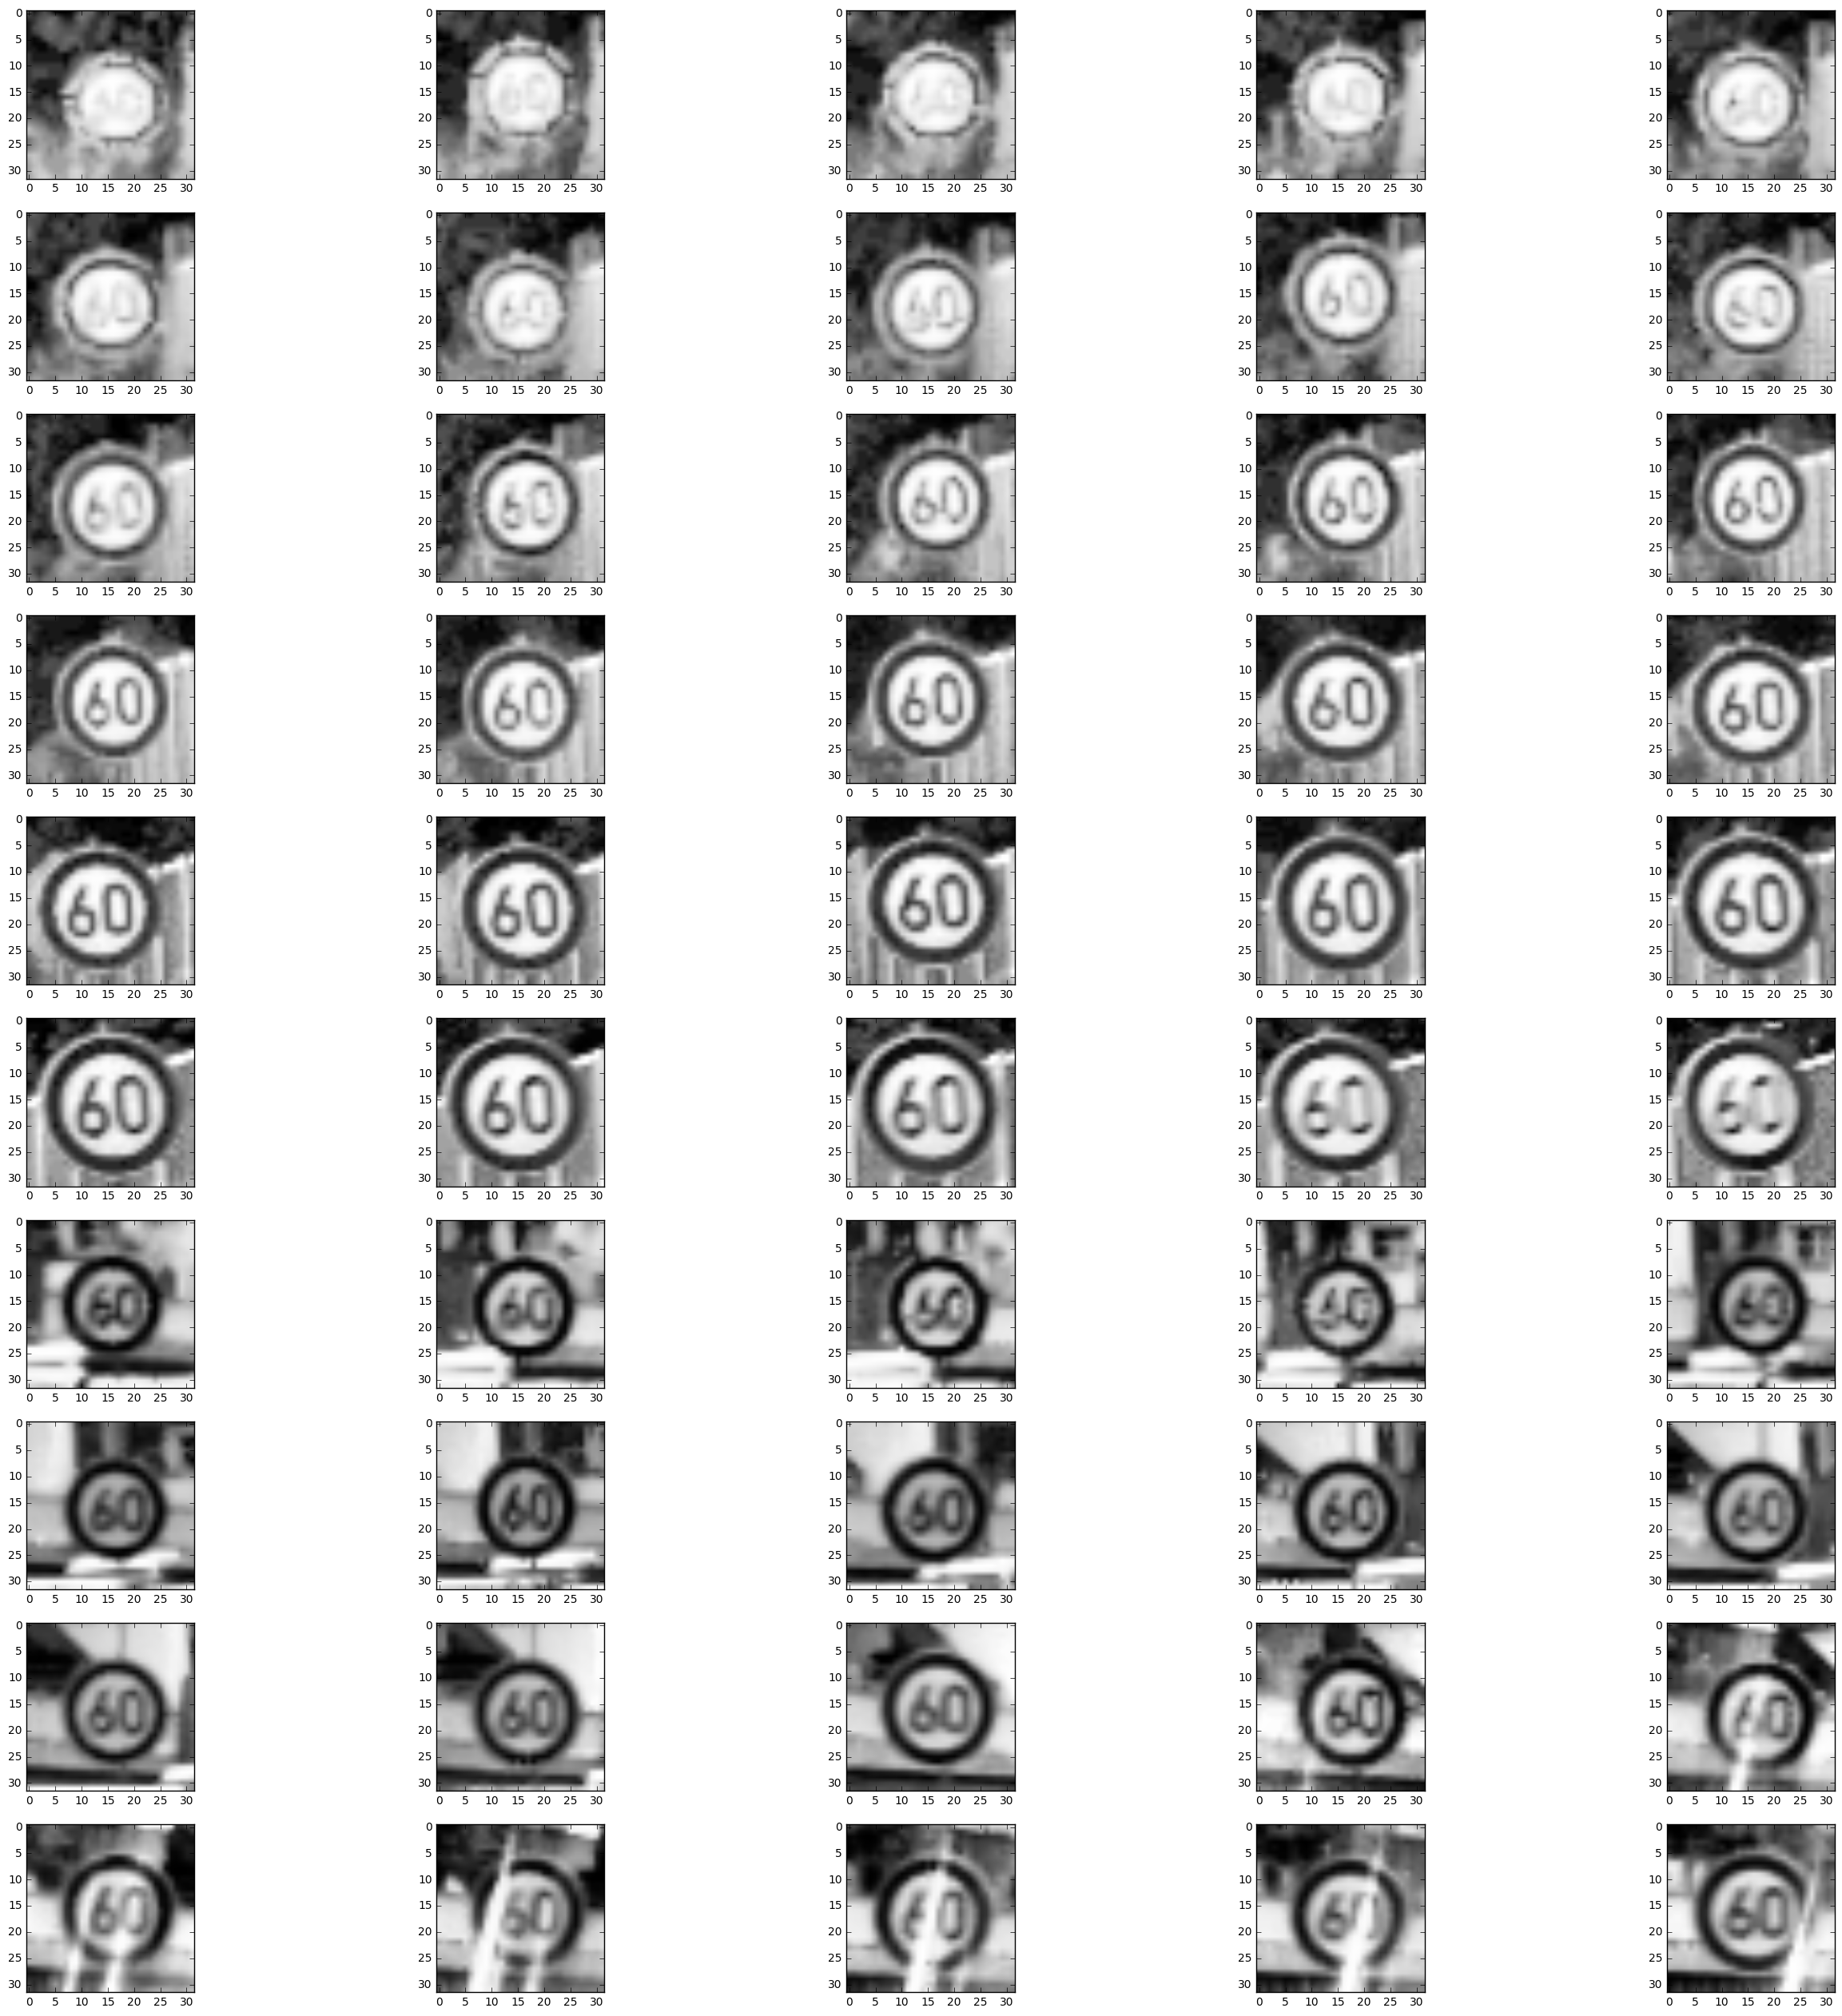

In [38]:
figure, axes = plt.subplots(10, 5, figsize=(32,32))
speed_limit_60 = []
count = 0
for i in range(len(X_proc)):
    if (y_train[i] == 3):
        count += 1
        img = X_proc[i]
        speed_limit_60.append(img)
idx=0
for rows in range(10):
    for columns in range(5):
        image = speed_limit_60[idx]
        axes[rows,columns].imshow(image, cmap="gray")
        idx+=1
plt.show()

In [39]:
new_images = np.reshape(new_images, (-1,32,32,1))
new_labels = [17,3,40,28,18]
new_labels = np.asarray(new_labels).astype(np.uint8)

In [40]:
# training features vs validation features
print(train_features.dtype, valid_features.dtype)
# training features vs test features
print(train_features.dtype, X_proc_test.dtype)
# train labels vs validation labels
print(train_labels.dtype, valid_labels.dtype)
# train labels vs test labels
print(train_labels.dtype, y_test.dtype)

# training features vs validation features
print(train_features.shape, valid_features.shape)
# training features vs test features
print(train_features.shape, X_proc_test.shape) 
# train labels vs validation labels
print(train_labels.shape, valid_labels.shape)
# train labels vs test labels
print(train_labels.shape, y_test.shape)

print(new_images.dtype, new_labels.dtype)
print(train_labels.shape, new_labels.shape)

float64 float64
float64 float64
uint8 uint8
uint8 uint8
(31367, 32, 32, 1) (7842, 32, 32, 1)
(31367, 32, 32, 1) (12630, 32, 32)
(31367,) (7842,)
(31367,) (12630,)
float64 uint8
(31367,) (5,)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



I don't see any particular qualities in these 5 images that would make classification difficult, do you? The perspective looks good, there are no artifacts blocking important features of the image, etc.

**Answer:**

In [41]:
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, './lenet')
    
    accuracy = evaluate(new_images, new_labels, 1.0)
    print("New Images Accuracy:  {:.3f}".format(accuracy))

# with tf.Session() as sess:
#     #saver.restore(sess, tf.train.latest_checkpoint('.'))
#     saver.restore(sess, './lenet')
    
#     accuracy = evaluate(np.asarray(img), [3], 1.0)
#     print("New Images Accuracy:  {:.3f}".format(accuracy))

New Images Accuracy:  0.800


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [27]:
prediction = tf.argmax(tf.nn.softmax(logits),1) # returns the index of the softmax prediction
top_5 = tf.nn.top_k(tf.nn.softmax(logits), k=5) # returns the top 5 softmax preditions and their indices 
saver = tf.train.Saver()

def pred_evaluate(X_data, y_data):
    sess = tf.get_default_session()
    pred = sess.run(top_5, feed_dict={x: X_data, y: y_data, keep_prob: 1.0})
    return pred

with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, './lenet')
    
    vals, top5 = sess.run([prediction, top_5], feed_dict={x:new_images, y: new_labels, keep_prob: 1.0})
    #pred = pred_evaluate(new_images, new_labels)
    #values, indices = tf.nn.top_k(pred, k=3, name="Top_K_Predictions")
print("New Image Actuals: ", new_labels)
print("Predictions: ", vals)
print("top 5 in predictions: ", top5)


New Image Actuals:  [17  3 40 28 18]
Predictions:  [17  2 40 28 18]
top 5 in predictions:  TopKV2(values=array([[  1.00000000e+00,   8.05700040e-09,   1.06754960e-09,
          9.83855553e-10,   5.98348981e-10],
       [  9.82328594e-01,   1.55634526e-02,   1.17944030e-03,
          8.70120944e-04,   4.46619197e-05],
       [  6.68812931e-01,   3.06812286e-01,   2.27136295e-02,
          1.15154218e-03,   1.56783222e-04],
       [  8.53180230e-01,   1.43348604e-01,   2.41344608e-03,
          8.99571285e-04,   1.16546413e-04],
       [  9.43689704e-01,   2.33914163e-02,   1.34510584e-02,
          9.03536938e-03,   3.06628691e-03]], dtype=float32), indices=array([[17, 34, 33, 40,  9],
       [ 2,  3,  1,  5,  6],
       [40, 12, 18, 16, 37],
       [28, 24, 29, 30, 23],
       [18, 29, 24, 26, 28]], dtype=int32))


My Model has performed much better on the new images after adding a dropout layer and histogram equalization to the preprocessing pipeline! 

Test accuaracy improved to 92.7% and the new images accuracy improved to 80%! I'm still really surprised that the model did not correctly predict the 60km/h traffic sign. I printed out 50 of the training 60km/h signs to verify the quality of the training data. The image quality seems to be ok.  

The machine did pick the correct sign for it's second best guess though the probability of that second guess was still quite low.

For some reason, there is something about my test image that gives the machine high confidence that the sign is 50km/h and not 60. I'm still not sure why that is. If I had more time I would feed the network more 60km/h images and continue to finetune the network.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


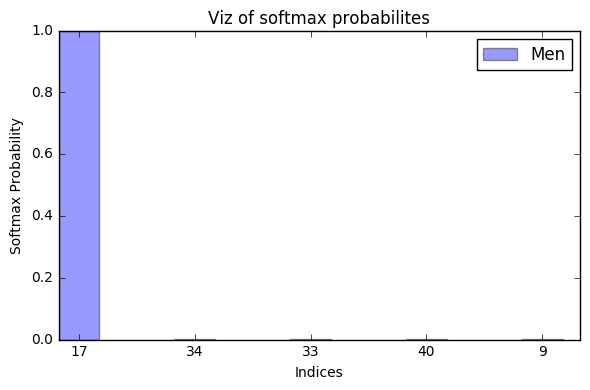

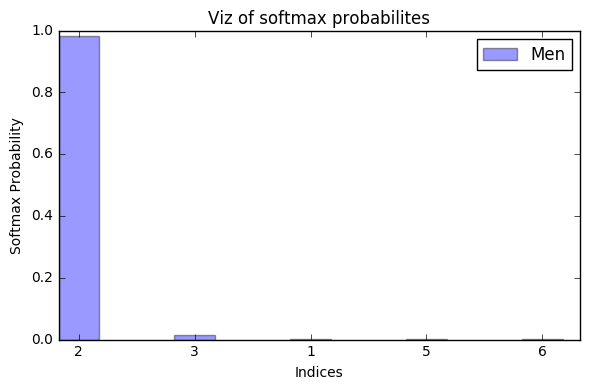

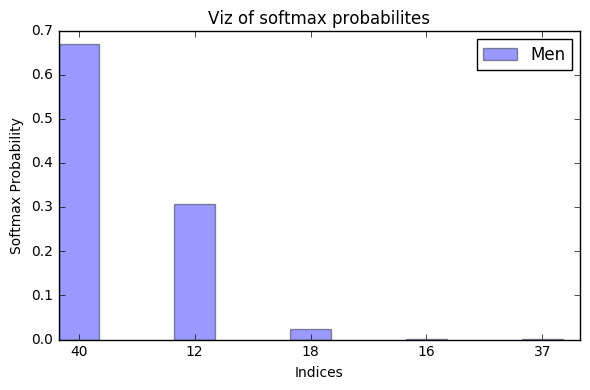

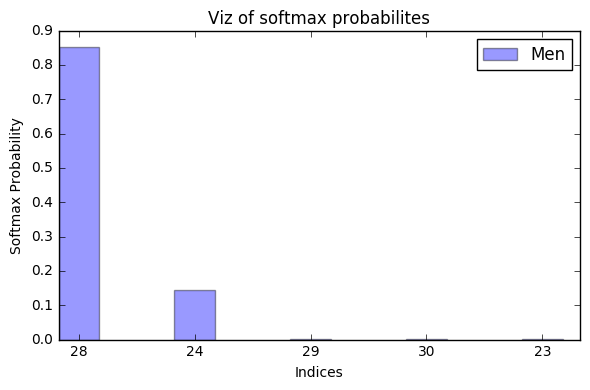

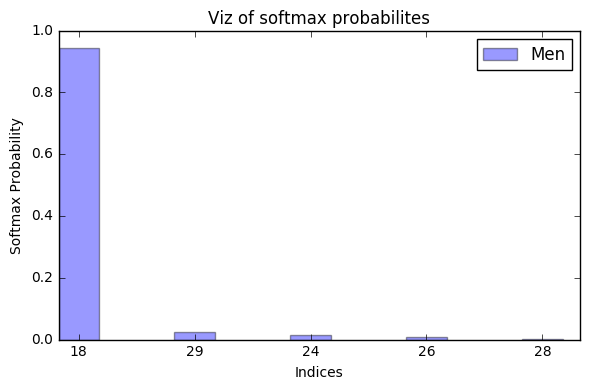

In [28]:
for i in range(5):
    n_groups = 5
    y = top5[0][i]
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.4

    rects1 = plt.bar(index, y, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Men')


    plt.xlabel('Indices')
    plt.ylabel('Softmax Probability')
    plt.title('Viz of softmax probabilites')
    plt.xticks(index + bar_width / 2, top5[1][i])
    plt.legend()

    plt.tight_layout()
plt.show()

This question has been mostly answered in the code cell above. The model is certain of the 1st, 3rd, and 4th images with respective softmax probabilites close to 1. The other images have softmax probabilites closer to 0.5 (uncertain). Strangely, the correct predictions do not appear in the model's top 5 predictions.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


I saved my model as 'lenet' and ran a slightly modified form of the evaluation pipeline against the new images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.